In [124]:
# Shuffle data and tokenize headline column

import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import matplotlib.pyplot as plt
import sys

import math
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

from collections import Counter

from sklearn import linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [125]:
# Combine both datasets into one dataframe
data = pd.read_json('Sarcasm_Headlines_Dataset.json', lines=True)
data = pd.merge(data, pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True))
data.shape[0]

26712

# EDA and data cleaning

In [126]:
# Split into train, validation, and test - 80% train, 10% validation, 10% test
train_df, test_df = train_test_split(data, test_size=0.2)
test_df, validation_df = train_test_split(test_df, test_size=0.5)

In [127]:
print(train_df.shape[0])
print(validation_df.shape[0])
print(test_df.shape[0])

21369
2672
2671


In [128]:
# Reset index to perform analysis.
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
train_df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/11-unexpe...,11 unexpected ways to use grapefruit,0
1,https://www.huffingtonpost.com/entry/men-behav...,men behaving badly,0
2,https://politics.theonion.com/obama-romney-urg...,"obama, romney urge americans to purchase 'the ...",1
3,https://entertainment.theonion.com/tommy-lee-j...,tommy lee jones tells jimmy fallon he doesn't ...,1
4,https://www.huffingtonpost.com/entry/otto-warm...,"otto warmbier, u.s. student freed from north k...",0


In [129]:
# Find corpus size...borrowed concepts from my code from a HW assignment
num_words = 0
word_list = []
num_word_list = []
for i in range(0, len(train_df)):
  words = train_df['headline'][i].split()
  word_list.extend(words)
  num_word_list.append(len(words))
  num_words = num_words + len(words)
print(num_words)

# Vocabulary size.
vocab_list = nltk.lm.Vocabulary(word_list)
print(len(vocab_list))

210647
32310


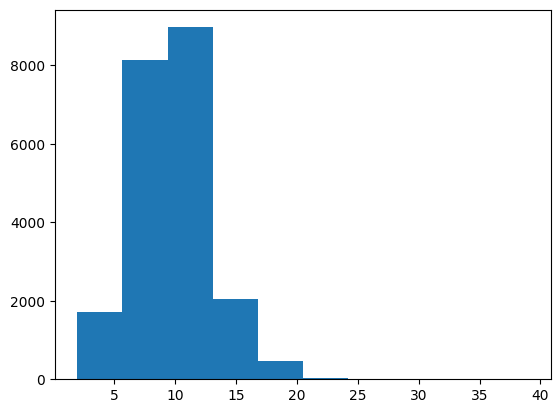

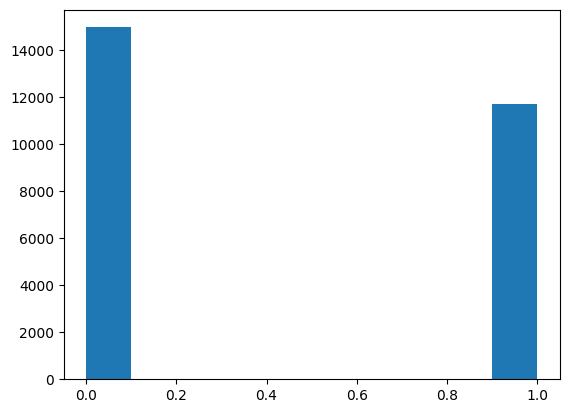

Average words per title: 9.857597454256165
Minimum words per title: 2
Maximum words per title: 39
Sarcastic to serious ratio: 0.4389412997903564


In [130]:
# Borrowed some concepts from my HW code

# Words per title
plt.hist(num_word_list)
plt.show()

# Plot class distribution
plt.hist(data['is_sarcastic'])
plt.show()

print('Average words per title: ' + str(sum(num_word_list) / len(num_word_list)))
print('Minimum words per title: ' + str(data['headline'].str.split().apply(len).min()))
print('Maximum words per title: ' + str(data['headline'].str.split().apply(len).max()))
print('Sarcastic to serious ratio: ' + str(data['is_sarcastic'].sum()/data['is_sarcastic'].shape[0]))

In [131]:
# Remove article link
train_df.drop(labels='article_link', axis=1, inplace=True)
validation_df.drop(labels='article_link', axis=1, inplace=True)
test_df.drop(labels='article_link', axis=1, inplace=True)
train_df.shape[0]

21369

In [132]:
# Drop duplicate rows
train_df.drop_duplicates(inplace=True)
validation_df.drop_duplicates(inplace=True)
test_df.drop_duplicates(inplace=True)

train_df.shape[0]

21290

In [133]:
# Drop rows with NA values
train_df.dropna(inplace=True)
validation_df.dropna(inplace=True)
test_df.dropna(inplace=True)

train_df.shape[0]

21290

In [134]:
# Ensure the is_sarcastic column only contains 1s and 0s
train_df[(train_df.is_sarcastic <= 1)]
train_df[(train_df.is_sarcastic >= 0)]
validation_df[(validation_df.is_sarcastic <= 1)]
validation_df[(validation_df.is_sarcastic >= 0)]
test_df[(test_df.is_sarcastic <= 1)]
test_df[(test_df.is_sarcastic >= 0)]

train_df.shape[0]

21290

In [135]:
# Reset index after data cleaning
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [136]:
# Remove stop words
stop_words = set(stopwords.words('english'))

for i in range(0, train_df['headline'].shape[0]):
  words = train_df['headline'][i].split()
  removed_stop_words = [x for x in words if not x.lower() in stop_words]
  train_df['headline'][i] = ' '.join(removed_stop_words)

for i in range(0, validation_df['headline'].shape[0]):
  words = validation_df['headline'][i].split()
  removed_stop_words = [x for x in words if not x.lower() in stop_words]
  validation_df['headline'][i] = ' '.join(removed_stop_words)

for i in range(0, test_df['headline'].shape[0]):
  words = test_df['headline'][i].split()
  removed_stop_words = [x for x in words if not x.lower() in stop_words]
  test_df['headline'][i] = ' '.join(removed_stop_words)

In [137]:
train_df.shape[0]

21290

In [138]:
train_df.head(10)

,headline,is_sarcastic
0,11 unexpected ways use grapefruit,0
1,men behaving badly,0
2,"obama, romney urge americans purchase 'the oni...",1
3,tommy lee jones tells jimmy fallon want play l...,1
4,"otto warmbier, u.s. student freed north korea,...",0
5,learning complex communications experiment home,0
6,north korea rings new year promises interconti...,0
7,milla jovovich inducted basic cable hall fame,1
8,embarrassing skin problem nobody talks,0
9,funniest tweets women week,0


In [139]:
# Reset indices after data processing
train_df.reset_index(drop=True, inplace=True)
validation_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [140]:
# Lemmatization
lem = WordNetLemmatizer()

for i in range(0, train_df['headline'].shape[0]):
  train_df['headline'][i] = lem.lemmatize(train_df['headline'][i])

for i in range(0, validation_df['headline'].shape[0]):
  validation_df['headline'][i] = lem.lemmatize(validation_df['headline'][i])

for i in range(0, test_df['headline'].shape[0]):
  test_df['headline'][i] = lem.lemmatize(test_df['headline'][i])

In [141]:
# Tokenize the headline column so that the model can understand the input.
tk_train = Tokenizer()
tk_train.fit_on_texts(train_df['headline'])
train_df['headline_tokenized'] = tk_train.texts_to_sequences(train_df['headline'])

tk_valid = Tokenizer()
tk_valid.fit_on_texts(validation_df['headline'])
validation_df['headline_tokenized'] = tk_valid.texts_to_sequences(validation_df['headline'])

tk_test = Tokenizer()
tk_test.fit_on_texts(test_df['headline'])
test_df['headline_tokenized'] = tk_test.texts_to_sequences(test_df['headline'])

In [142]:
train_df.head()

,headline,is_sarcastic,headline_tokenized
0,11 unexpected ways use grapefruit,0,"[227, 2297, 163, 236, 13154]"
1,men behaving badly,0,"[217, 13155, 5000]"
2,"obama, romney urge americans purchase 'the oni...",1,"[21, 404, 2127, 35, 1995, 61, 3138, 207, 1769,..."
3,tommy lee jones tells jimmy fallon want play l...,1,"[5001, 1770, 899, 372, 623, 2881, 95, 558, 96,..."
4,"otto warmbier, u.s. student freed north korea,...",0,"[7140, 9201, 7, 10, 271, 5832, 145, 405, 13156..."


# LSTM model

I used this link for inspiration on the model design: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/

In [143]:
# This type of model requires a fixed width column, so find the largest
# width to pad to
train_pad = max(len(x) for x in train_df.headline_tokenized)
validation_pad = max(len(x) for x in validation_df.headline_tokenized)
test_pad = max(len(x) for x in test_df.headline_tokenized)
pad_len = max(train_pad, validation_pad, test_pad)

In [144]:
# train_df['headline_tokenized'] = pad_sequences(train_df['headline_tokenized'], maxlen=pad_len)
x_train = pad_sequences(train_df['headline_tokenized'], maxlen=pad_len, padding='post', dtype='float32')
y_train = train_df['is_sarcastic'].values

x_valid = pad_sequences(validation_df['headline_tokenized'], maxlen=pad_len, padding='post', dtype='float32')
y_valid = validation_df['is_sarcastic'].values

x_test = pad_sequences(test_df['headline_tokenized'], maxlen=pad_len, padding='post', dtype='float32')
y_test = np.reshape(test_df['is_sarcastic'].values, (-1,1))

In [145]:
# Find new vocabulary size after data cleaning
num_words = 0
word_list = []
num_word_list = []
for i in range(0, len(train_df)):
  words = train_df['headline'][i].split()
  word_list.extend(words)
  num_word_list.append(len(words))
  num_words = num_words + len(words)
print(num_words)

# Vocabulary size.
vocab_list = nltk.lm.Vocabulary(word_list)
print(len(vocab_list))

152451
32158


In [146]:
lstm_model = Sequential()
lstm_model.add(Embedding(input_dim=len(vocab_list), output_dim=x_train.shape[1], input_length=x_train.shape[1]))
lstm_model.add(LSTM(50))
lstm_model.add(Dropout(0.2))
# lstm_model.add(Embedding(input_dim=len(vocab_list), output_dim=x_train.shape[1], input_length=x_train.shape[1]))
# lstm_model.add(LSTM(100))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 34, 34)            1093372   
                                                                 
 lstm_3 (LSTM)               (None, 50)                17000     
                                                                 
 dropout_3 (Dropout)         (None, 50)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 51        
                                                                 
Total params: 1,110,423
Trainable params: 1,110,423
Non-trainable params: 0
_________________________________________________________________
None


In [147]:
lstm_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=64)

Epoch 1/10
333/333 [==============================] - 19s 47ms/step - loss: 0.5372 - accuracy: 0.7157 - val_loss: 0.9198 - val_accuracy: 0.5148
Epoch 2/10
333/333 [==============================] - 16s 47ms/step - loss: 0.2664 - accuracy: 0.8954 - val_loss: 1.2070 - val_accuracy: 0.5114
Epoch 3/10
333/333 [==============================] - 15s 45ms/step - loss: 0.1494 - accuracy: 0.9480 - val_loss: 1.6775 - val_accuracy: 0.5137
Epoch 4/10
333/333 [==============================] - 15s 45ms/step - loss: 0.0933 - accuracy: 0.9713 - val_loss: 1.8713 - val_accuracy: 0.5140
Epoch 5/10
333/333 [==============================] - 15s 45ms/step - loss: 0.0673 - accuracy: 0.9801 - val_loss: 2.1550 - val_accuracy: 0.5253
Epoch 6/10
333/333 [==============================] - 16s 47ms/step - loss: 0.0509 - accuracy: 0.9860 - val_loss: 2.4699 - val_accuracy: 0.5144
Epoch 7/10
333/333 [==============================] - 16s 48ms/step - loss: 0.0423 - accuracy: 0.9891 - val_loss: 2.4966 - val_accuracy:

In [148]:
sys.getsizeof(lstm_model)

48

### Results

In [149]:
results = lstm_model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: " + str((results[1]*100)))

Accuracy: 51.14189386367798


# Decision Tree Model

##### Borrowed code from one of my HW assignments

In [150]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(x_train, y_train)

DecisionTreeClassifier()

In [151]:
print('Mean accuracy: ' + str(cross_val_score(decision_tree, x_train, y_train).mean() * 100))

Mean accuracy: 58.046031000469696


In [152]:
print('Mean accuracy: ' + str(cross_val_score(decision_tree, x_valid, y_valid).mean() * 100))

Mean accuracy: 55.37183660611152


In [153]:
print(decision_tree.score(x_test, y_test) * 100)

53.05129165106701


In [154]:
sys.getsizeof(decision_tree)

48

# Logistic Regression Model

#### Borrowed code from one of my HW assignments

In [155]:
logistic_regression = linear_model.LogisticRegression()
logistic_regression.fit(x_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [156]:
print('Mean accuracy: ' + str(cross_val_score(logistic_regression, x_valid, y_valid).mean() * 100))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Mean accuracy: 56.943960236620114


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [157]:
print(logistic_regression.score(x_test, y_test) * 100)

56.907525271433926


In [158]:
sys.getsizeof(logistic_regression)

48